# 0. Introdução

A base de dados analisada contém informações de clientes de uma instituição financeira, tais como escolaridade, estado civil, salário anual e histórico de transações, bem como informação se o cliente encontra-se inadimplente ou não (representada pela coluna ***default***). Destaca-se que ***default* = 1** são clientes com pagamento atrasado enquanto ***defaut* = 0** são clientes com pagamento em dia.

Deseja-se investigar a relação entre ***default*** e os demais atributos com o objetivo de explicar aquela variável e determinar o perfil de cliente para o qual a instituição financeira deve focar ações para reduzir o nível de inadimplência.

# 1. Importação de bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  2. Carregamento dos dados

In [3]:
URL = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/develop/dataset/credito.csv'
df = pd.read_csv(URL, na_values = 'na' )
df.head(6)

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28
5,713061558,0,44,M,2,mestrado,casado,$40K - $60K,blue,36,3,2,1,"4.010,69","1.088,07",24


# 3. Exploração dos dados

In [4]:
total = df.shape
print(f'Total de clientes: {total[0]}')


Total de clientes: 10127


In [5]:
adimp = df[df['default'] == 0].shape #quantidade de clientes adimplentes
print(f'Total de clientes adimplentes: {adimp[0]} ({round(100 * adimp[0]/total[0], 2)}% do total)')


Total de clientes adimplentes: 8500 (83.93% do total)


In [6]:
inad = df[df['default'] == 1].shape #quantidade de clientes inadiplentes
print(f'Total de clientes inadimplentes: {inad[0]} ({round(100 * inad[0]/total[0], 2)}% do total)')

Total de clientes inadimplentes: 1627 (16.07% do total)


In [7]:
df.dtypes

id                          int64
default                     int64
idade                       int64
sexo                       object
dependentes                 int64
escolaridade               object
estado_civil               object
salario_anual              object
tipo_cartao                object
meses_de_relacionamento     int64
qtd_produtos                int64
iteracoes_12m               int64
meses_inativo_12m           int64
limite_credito             object
valor_transacoes_12m       object
qtd_transacoes_12m          int64
dtype: object

In [8]:
df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436
limite_credito,10127,9272,"1.438,21",11
valor_transacoes_12m,10127,10035,"3.851,51",3


In [9]:
df.drop('id', 1).select_dtypes('number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
default,10127.0,0.160660,0.367235,0.0,0.0,0.0,0.0,1.0
idade,10127.0,46.325960,8.016814,26.0,41.0,46.0,52.0,73.0
dependentes,10127.0,2.346203,1.298908,0.0,1.0,2.0,3.0,5.0
meses_de_relacionamento,10127.0,35.928409,7.986416,13.0,31.0,36.0,40.0,56.0
qtd_produtos,10127.0,3.812580,1.554408,1.0,3.0,4.0,5.0,6.0
iteracoes_12m,10127.0,2.455317,1.106225,0.0,2.0,2.0,3.0,6.0
meses_inativo_12m,10127.0,2.341167,1.010622,0.0,2.0,2.0,3.0,6.0
qtd_transacoes_12m,10127.0,64.858695,23.472570,10.0,45.0,67.0,81.0,139.0


In [10]:
df.isna().any()

id                         False
default                    False
idade                      False
sexo                       False
dependentes                False
escolaridade                True
estado_civil                True
salario_anual               True
tipo_cartao                False
meses_de_relacionamento    False
qtd_produtos               False
iteracoes_12m              False
meses_inativo_12m          False
limite_credito             False
valor_transacoes_12m       False
qtd_transacoes_12m         False
dtype: bool

As variáveis **'limite_credito'** e **'valor_transacoes_12m'** estão listadas no tipo textual *object* e precisam ser convertidas para o tipo *float*, já que são valores monetários e podem assumir qualquer valor maior que zero.

As colunas **'escolaridade'**, **'estado_civil'** e **'salario_anual'** contêm dados nulos, que devem ser tratados.

In [11]:
def dados_faltantes(df: pd.DataFrame) -> None:
    faltantes = []
    for coluna in df.columns:
        if df[coluna].isna().any():
            qtd, _ = df[df[coluna].isna()].shape
            total, _ = df.shape
            faltantes_coluna = {coluna: {'quantidade': qtd, 'proporção': str(round(100 * qtd/total, 2)) + '%'}}
            faltantes.append(faltantes_coluna)
    
    for faltante in faltantes:
        print(faltante)

In [12]:
#proporção total por atributo de dados faltantes de clientes
dados_faltantes(df) 

{'escolaridade': {'quantidade': 1519, 'proporção': '15.0%'}}
{'estado_civil': {'quantidade': 749, 'proporção': '7.4%'}}
{'salario_anual': {'quantidade': 1112, 'proporção': '10.98%'}}


In [13]:
#propoção por atributo de dados faltantes de clientes adimplentes
dados_faltantes(df[df['default']==0]) 

{'escolaridade': {'quantidade': 1263, 'proporção': '14.86%'}}
{'estado_civil': {'quantidade': 620, 'proporção': '7.29%'}}
{'salario_anual': {'quantidade': 925, 'proporção': '10.88%'}}


In [14]:
#propoção por atributo de dados faltantes de clientes inadimplentes
dados_faltantes(df[df['default']==1]) 

{'escolaridade': {'quantidade': 256, 'proporção': '15.73%'}}
{'estado_civil': {'quantidade': 129, 'proporção': '7.93%'}}
{'salario_anual': {'quantidade': 187, 'proporção': '11.49%'}}


Verificou-se que a porcentagem de dados faltantes por atributo se mantém tanto para os clientes adimplentes quanto para os clientes inadimplentes. Assim, eliminar as linhas que contêm algum dado nulo não alteraria de forma signicativa as proporções originais e não causaria prejuízo ao objetivo da pesquisa.

# 4. Limpeza e tranformação

* Correção do schema

As colunas **'limite_credito'** e **'valor_transacoes_12m'** estão no formato brasileiro de número (vírgula separando as casas decimais e ponto separando as casas de milhares) e devem ser transformadas para o formato internacional (ponto separando as casas decimais) para que se possa convertê-las do tipo *string* para o tipo *float*.

In [15]:
df['limite_credito'] = df['limite_credito'].apply(lambda valor: float(valor.replace('.','').replace(',','.')))
df['valor_transacoes_12m'] = df['valor_transacoes_12m'].apply(lambda valor: float(valor.replace('.','').replace(',','.')))

    Visualização do novo schema

In [16]:
df.dtypes

id                           int64
default                      int64
idade                        int64
sexo                        object
dependentes                  int64
escolaridade                object
estado_civil                object
salario_anual               object
tipo_cartao                 object
meses_de_relacionamento      int64
qtd_produtos                 int64
iteracoes_12m                int64
meses_inativo_12m            int64
limite_credito             float64
valor_transacoes_12m       float64
qtd_transacoes_12m           int64
dtype: object

In [17]:
df.drop('id', 1).select_dtypes('number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
default,10127.0,0.160660,0.367235,0.00,0.000,0.00,0.000,1.00
idade,10127.0,46.325960,8.016814,26.00,41.000,46.00,52.000,73.00
dependentes,10127.0,2.346203,1.298908,0.00,1.000,2.00,3.000,5.00
meses_de_relacionamento,10127.0,35.928409,7.986416,13.00,31.000,36.00,40.000,56.00
qtd_produtos,10127.0,3.812580,1.554408,1.00,3.000,4.00,5.000,6.00
iteracoes_12m,10127.0,2.455317,1.106225,0.00,2.000,2.00,3.000,6.00
meses_inativo_12m,10127.0,2.341167,1.010622,0.00,2.000,2.00,3.000,6.00
limite_credito,10127.0,8632.440165,9088.788041,1438.00,2555.355,4549.42,11068.175,34516.99
valor_transacoes_12m,10127.0,4404.583047,3397.128078,510.16,2155.825,3899.59,4741.310,18484.93
qtd_transacoes_12m,10127.0,64.858695,23.472570,10.00,45.000,67.00,81.000,139.00


* Remoção de dados faltantes

In [18]:
df = df.dropna()

In [19]:
df.isna().any()

id                         False
default                    False
idade                      False
sexo                       False
dependentes                False
escolaridade               False
estado_civil               False
salario_anual              False
tipo_cartao                False
meses_de_relacionamento    False
qtd_produtos               False
iteracoes_12m              False
meses_inativo_12m          False
limite_credito             False
valor_transacoes_12m       False
qtd_transacoes_12m         False
dtype: bool

In [20]:
total_nova = df.shape
adimp_nova = df[df['default']==0].shape
inad_nova = df[df['default']==1].shape

print(f'A proporção de clientes ADIMPLENTES era {round(100 * adimp[0]/total[0], 2)}%, e agora é {round(100 * adimp_nova[0]/total_nova[0], 2)}% ')
print(f'A proporção de clientes INADIMPLENTES era {round(100 * inad[0]/total[0], 2)}% e agora é {round(100 * inad_nova[0]/total_nova[0], 2)}% ')

A proporção de clientes ADIMPLENTES era 83.93%, e agora é 84.28% 
A proporção de clientes INADIMPLENTES era 16.07% e agora é 15.72% 


A proporção de clientes inadimplentes sofreu uma leve redução após a eliminação dos dados faltantes, no entanto, essa diferença é muito baixa e não acarreta perda significativa de informação.

# 5. Análise e visualização

In [21]:
sns.set_style('whitegrid')
df_adimplentes = df[df['default'] == 0]
df_inadimplentes = df[df['default'] == 1]

 * Visualizações categóricas  
 
  variáveis: *'escolaridade', 'estado_civil', 'salario_anual', 'tipo_cartao'*

Além do dataframe contendo as informações de todos os clientes, foi criado um dataframe contendo informações apenas de clientes adimplentes e um dataframe apenas de clientes inadimplentes.
A função abaixo será usada para criação de gráfico de frequência de cada variável categórica para os os três dataframes. 

In [22]:
def gerar_graficos(coluna: str, titulos: list) -> None: 
    
    eixo = 0
    max_y = 0
    max = df.select_dtypes('object').describe()[coluna]['freq'] * 1.1
    
    figura, eixos = plt.subplots(1, 3, figsize = (20,5), sharex = True)
    
    for dataframe in [df, df_adimplentes, df_inadimplentes]:
        df_to_plot = dataframe[coluna].value_counts().to_frame()
        df_to_plot.rename(columns={coluna: 'frequencia_absoluta'}, inplace=True)
        df_to_plot[coluna] = df_to_plot.index
        df_to_plot.sort_values(by=[coluna], inplace=True)
        df_to_plot.sort_values(by=[coluna])
        
        f = sns.barplot(x=df_to_plot[coluna], y=df_to_plot['frequencia_absoluta'], ax=eixos[eixo])
        f.set(title=titulos[eixo], xlabel=coluna, ylabel='Frequencia Absoluta')
        f.set_xticklabels(labels=f.get_xticklabels(), rotation=90)
        
        _, max_y_f = f.get_ylim()
        max_y = max_y_f if max_y_f > max_y else max_y
        f.set(ylim=(0,max_y))
        
        eixo += 1
        
    figura.show()

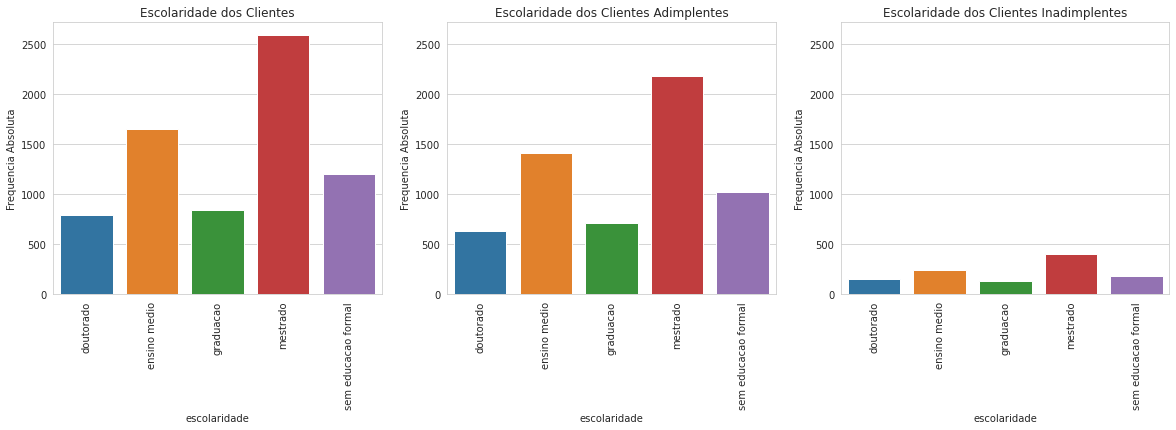

In [23]:
coluna = 'escolaridade'
titulos = ['Escolaridade dos Clientes', 'Escolaridade dos Clientes Adimplentes', 'Escolaridade dos Clientes Inadimplentes']
gerar_graficos(coluna, titulos)

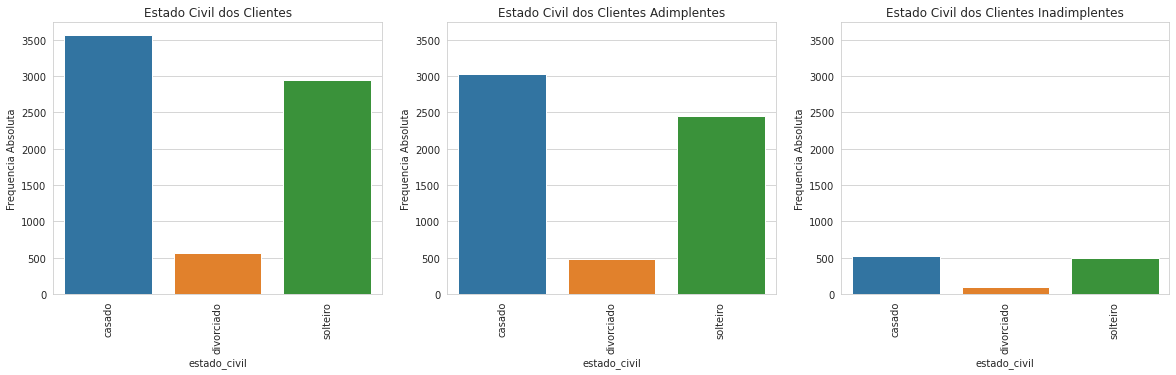

In [24]:
coluna = 'estado_civil'
titulos = ['Estado Civil dos Clientes', 'Estado Civil dos Clientes Adimplentes', 'Estado Civil dos Clientes Inadimplentes']
gerar_graficos(coluna, titulos)

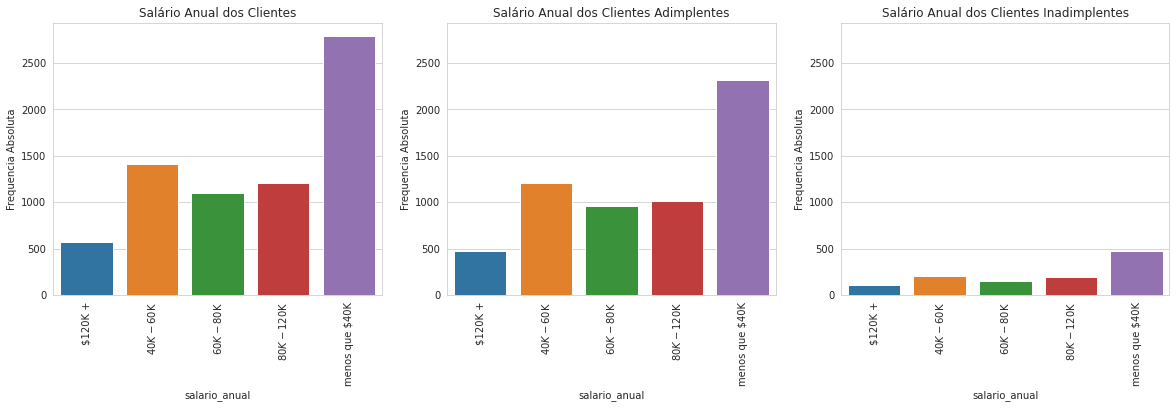

In [25]:
coluna = 'salario_anual'
titulos = ['Salário Anual dos Clientes', 'Salário Anual dos Clientes Adimplentes', 'Salário Anual dos Clientes Inadimplentes']
gerar_graficos(coluna, titulos)

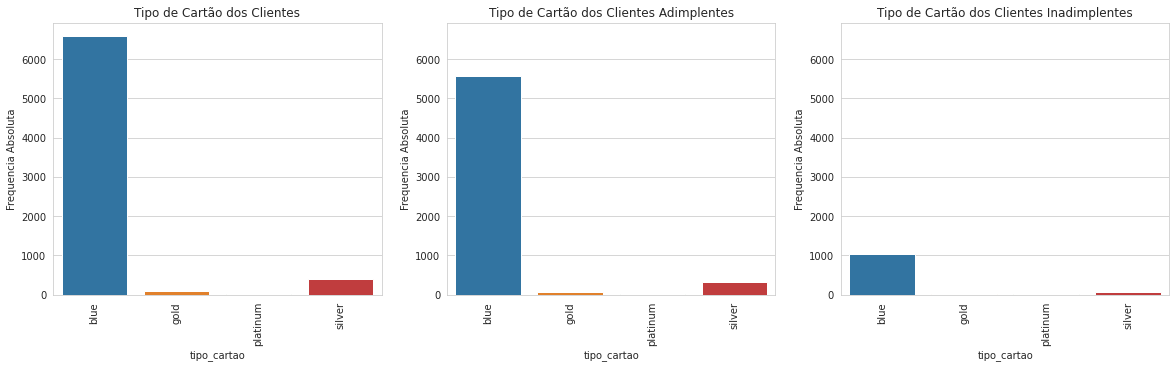

In [26]:
coluna = 'tipo_cartao'
titulos = ['Tipo de Cartão dos Clientes', 'Tipo de Cartão dos Clientes Adimplentes', 'Tipo de Cartão dos Clientes Inadimplentes']
gerar_graficos(coluna, titulos)

Não há evidências de que as variáveis categóricas **'escolaridade'**, **'salario_anual'** e **'estado_civil'** influenciem no comportamento de inadimplência do cliente, uma vez que a distribuição observada no dataframe completo parece se repetir tanto para clientes adimplentes quanto para clientes inadimplentes. Por outro lado, é interessante notar que, analisando rapidamente, clientes com cartão das categorias **gold** e **platinum** não parecem se tornar inadimplentes. No entanto, estes clientes configuram uma proporção pequena da amostra, **não sendo possível fazer qualquer tipo de afirmação nesse sentido**.

* Visualizações numéricas

 variáveis: *'idade', 'dependentes', 'meses_de_relacionamento', 'qtd_produtos', iteracoes_12m', 'meses_inativo_12m', 'limite_credito', 'valor_transacoes_12m', qtd_transacoes_12m'*

A função abaixo foi criada para gerar histogramas de cada váriavel númerica para os três grupos de dados (totalidade dos clintes, clientes adimplentes e clientes inadimplentes).

In [50]:
def gerar_histograma(coluna: str , titulos: list, numeros_inteiros: bool) -> None:
    eixo = 0
    max_y = 0
    figura, eixos = plt.subplots(1, 3, figsize=(20,5), sharex=True)
    
    for dataframe in [df, df_adimplentes, df_inadimplentes]:
        f = sns.histplot(x=coluna, data=dataframe, stat='count', ax=eixos[eixo],discrete = numeros_inteiros)
        f.set(title = titulos[eixo], xlabel=coluna, ylabel='Frequencia Absoluta')
        
        _, max_y_f = f.get_ylim()
        max_y = max_y_f if max_y_f > max_y else max_y
        f.set(ylim=(0, max_y))
        
        eixo += 1
        
    figura.show()

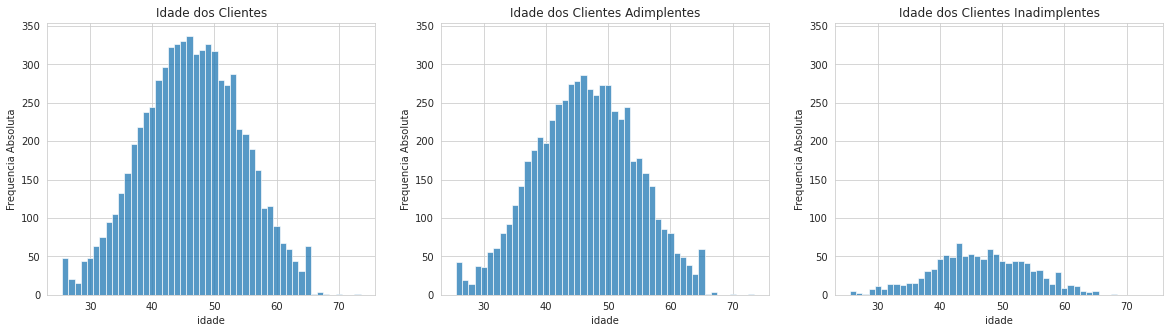

In [51]:
coluna = 'idade'
titulos = ['Idade dos Clientes', 'Idade dos Clientes Adimplentes', 'Idade dos Clientes Inadimplentes']
gerar_histograma(coluna, titulos, True)

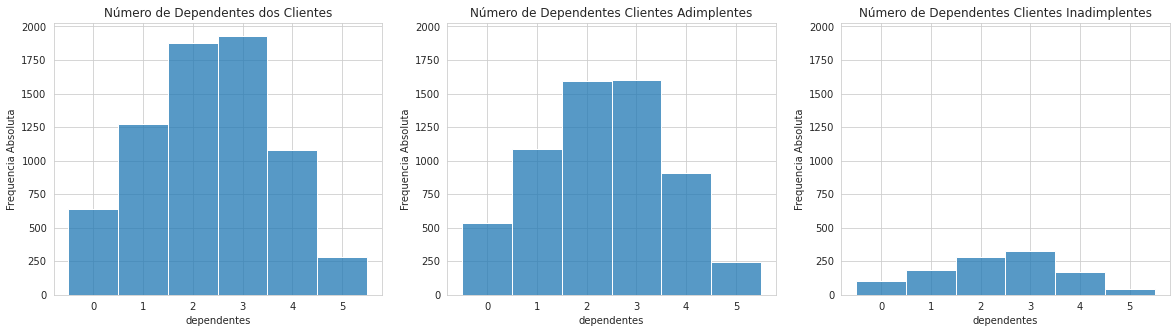

In [52]:
coluna = 'dependentes'
titulos = ['Número de Dependentes dos Clientes', 'Número de Dependentes Clientes Adimplentes', 'Número de Dependentes Clientes Inadimplentes']
gerar_histograma(coluna, titulos, True)

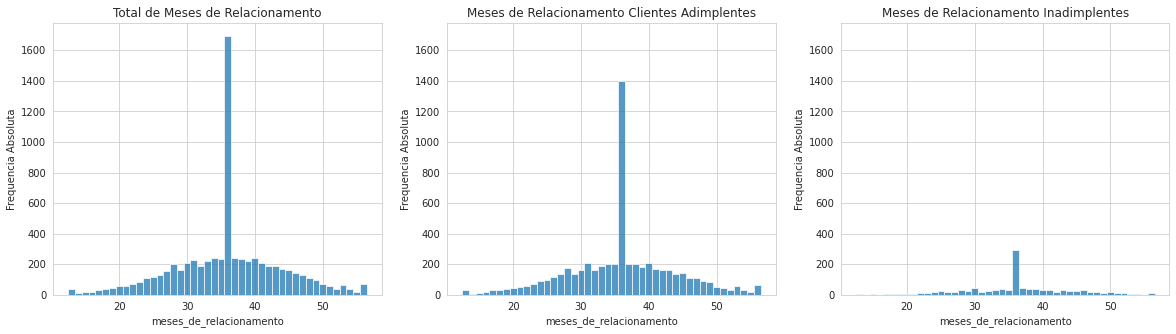

In [53]:
coluna = 'meses_de_relacionamento'
titulos = ['Total de Meses de Relacionamento', 'Meses de Relacionamento Clientes Adimplentes', 'Meses de Relacionamento Inadimplentes']
gerar_histograma(coluna, titulos, True)

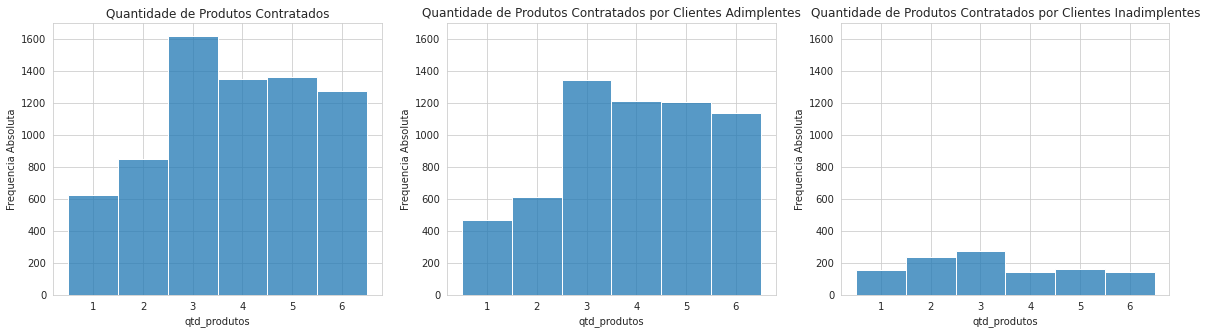

In [54]:
coluna = 'qtd_produtos'
titulos = ['Quantidade de Produtos Contratados', 'Quantidade de Produtos Contratados por Clientes Adimplentes', 'Quantidade de Produtos Contratados por Clientes Inadimplentes']
gerar_histograma(coluna, titulos, True)

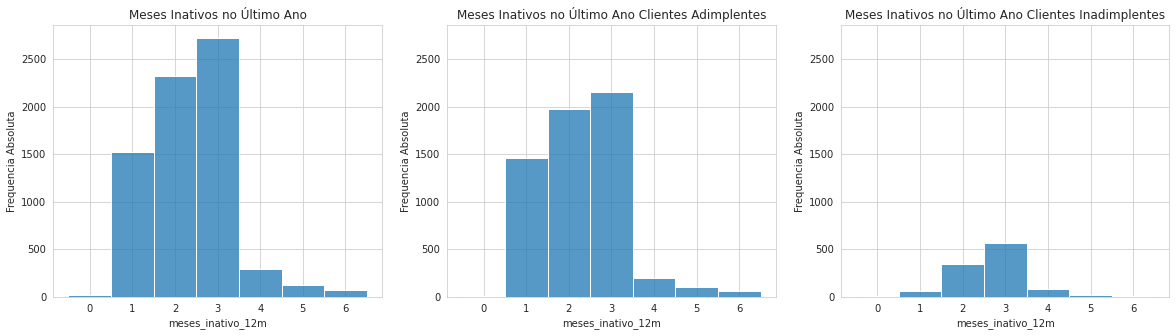

In [55]:
coluna = 'meses_inativo_12m'
titulos = ['Meses Inativos no Último Ano', 'Meses Inativos no Último Ano Clientes Adimplentes', 'Meses Inativos no Último Ano Clientes Inadimplentes']
gerar_histograma(coluna, titulos, True)

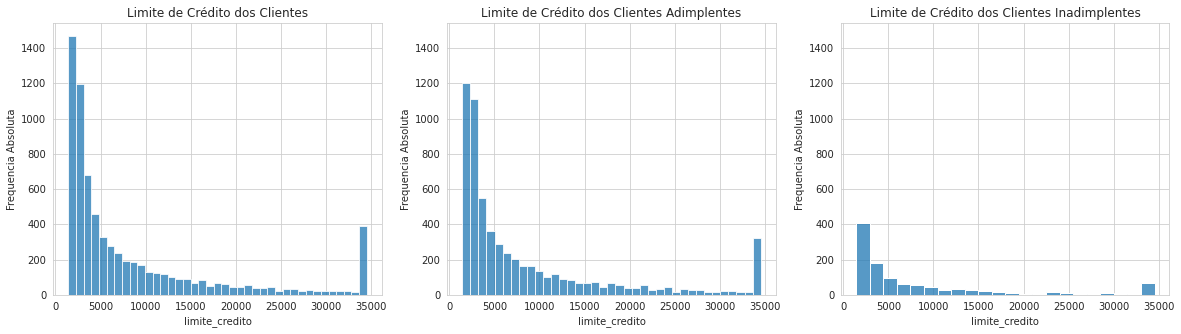

In [56]:
coluna = 'limite_credito'
titulos = ['Limite de Crédito dos Clientes', 'Limite de Crédito dos Clientes Adimplentes', 'Limite de Crédito dos Clientes Inadimplentes']
gerar_histograma(coluna, titulos, False)

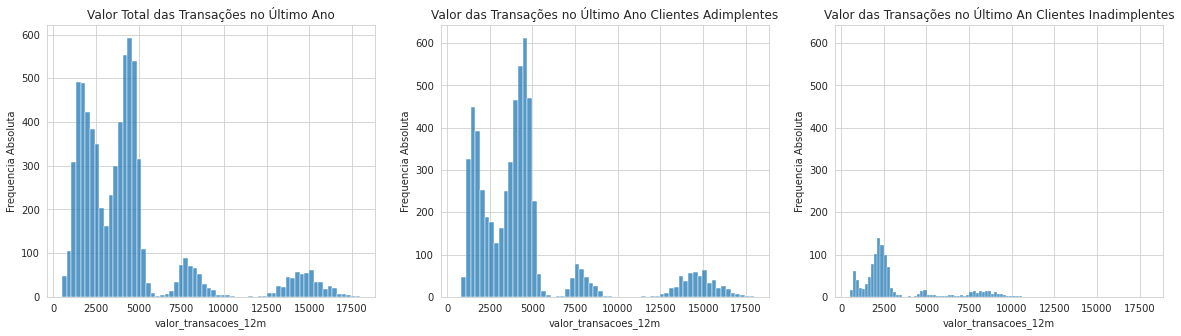

In [57]:
coluna = 'valor_transacoes_12m'
titulos = ['Valor Total das Transações no Último Ano', 'Valor das Transações no Último Ano Clientes Adimplentes', 'Valor das Transações no Último An Clientes Inadimplentes']
gerar_histograma(coluna, titulos, False)

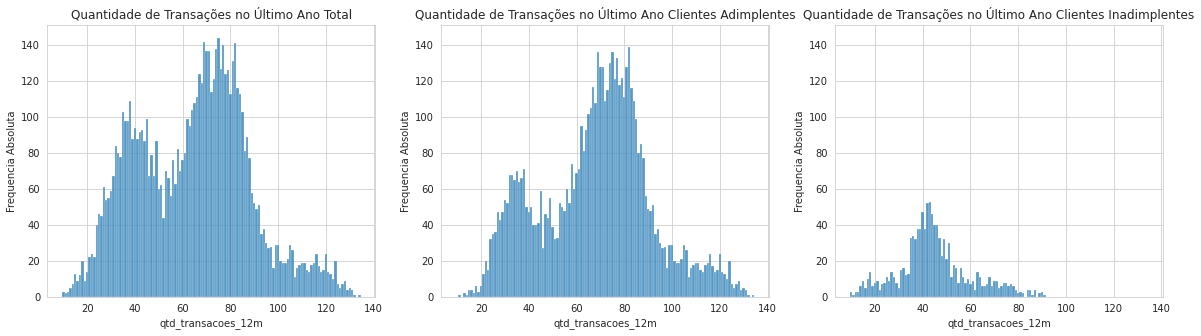

In [60]:
coluna = 'qtd_transacoes_12m'
titulos = ['Quantidade de Transações no Último Ano Total', 'Quantidade de Transações no Último Ano Clientes Adimplentes', 'Quantidade de Transações no Último Ano Clientes Inadimplentes']
gerar_histograma(coluna, titulos, True)

Analisando a variável **'qtd_produtos'**, verifica-se que a maioria dos clientes contratam 3 ou mais produtos financeiros, e esse comportamento se repete ao observar apenas os clientes que permanecem adimplentes. No entanto, ao analisar o comportamento de clientes inadimplentes, percebe-se que a maior parte destes contrata até 3 produtos financeiros.

As variáveis numéricas **'qtd_transacoes_12m'** e **'valor_transacoes_12m'** também parecem se relacionar com a variável resposta. 
A variável **'valor_transacoes_12m'** apresenta um pico em torno de 2500 reais quando se analisa clientes inadimplentes, que não aparece quando observa-se toda a base de dados
De forma análoga, a variável **'qtd_transacoes_12m'** para clientes inadimplentes se concentra entre 20 e 80 transações por ano, com pico em torno de 40, e nunca ultrapassando 100 transações por ano.


    Relação entre Valor de Transações x Quantidade de Transações nos últimos 12 meses

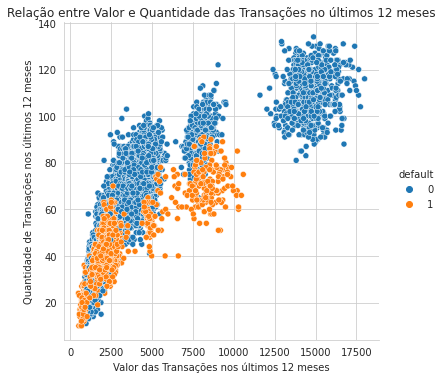

In [36]:
f = sns.relplot(x='valor_transacoes_12m', y='qtd_transacoes_12m', data=df, hue ='default')
_ = f.set(
    title = 'Relação entre Valor e Quantidade das Transações no últimos 12 meses',
    xlabel = 'Valor das Transações nos últimos 12 meses',
    ylabel = 'Quantidade de Transações nos últimos 12 meses'
)

Conforme esperado, ao serem plotados os valores de transação *versus* a quantidade de transações, percebe-se uma clara relação crescente entre eles: quanto maior a quantidade, maior o valor total.
Além disso, os clientes podem ser classificados em dois grupos, conforme seus gastos: 
* **Grupo 1**: proxímo de até 120 transações por ano, com gasto acumulado de até 11.000 reais, aproximadamente.
* **Grupo 2**: de 80 a 140 transações por ano, e gastos totais entre 11.000 e 18.000 reais, aproximadamente.

Não foi observado nenhum caso de inadimplência no grupo 2, dessa forma, os clientes que mais gastam tendem a estar em dia com suas obrigações. Estes dados também podem ser observados nos histogramas de quantidade de transações e valor das transações contruídos anteriormente.

Também é possível observar que, para um mesmo valor de transações, os clientes inadimplentes tendem a utilizar os serviços menos vezes. Por exemplo, considerando o serviço de cartão de crédito, os clientes inadimplentes realizam menos compras, porém de valores mais altos.
Subdivindo os clientes inadimplentes em **grupo A** (até 5.000 reais) e **grupo B** (de 5.000 a 11.000), observa-se que o grupo A não realiza mais que 80 transações e o grupo B não realiza mais que 100 transações por ano. Em contrapartida, os clientes adimplentes, quando divididos em subgrupos na mesma faixa de valor de transações, se limitam a pouco mais de, respectivamente, 100 e 120 transações por ano. Comparando com os resultados dos histogramas, constata-se que os clientes inadimplentes estão concentrados no **grupo A**, principalmente na faixa de **2.500 reais e 40 transações por ano**.


# 6. Conclusão

A partir dos resultados encontrados, é possível concluir que o comportamento de inadimplência não está relacionado com a renda do cliente, e sim com o seu histórico de uso dos serviços financeiros da instituição: estes clientes contratam menos serviços e transacionam menos que os clientes adimplentes

O foco das ações deve estar voltado para clientes do **grupo 1** (gastos de até 11.000 reais realizados em até 120 transações), prioritariamento do **grupo A** (até 5000 reais e até 80 transações) com gastos por volta de 2.500 reais e aproximadamente 40 transações por ano.